In [2]:
# 주요 라이브러리 
import nltk
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# Step 1. 데이터 수집하기

## 1) 데이터 로드

In [3]:
data = pd.read_csv('news_summary_more.csv')

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
data['headlines'][0]

'upGrad learner switches to career in ML & Al with 90% salary hike'

In [5]:
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

# Step 2. 데이터 전처리하기 (추상적 요약)

## 1) 중복 샘플 확인

In [6]:
# 데이터 크기 확인
data.shape

(98401, 2)

In [7]:
# 각 컬럼의 고유 샘플 수 확인
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [8]:
# 중복 샘플 제거
data.drop_duplicates(subset = ['text'], inplace=True)
data.shape

(98360, 2)

In [9]:
# 결측치 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [10]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 2) 텍스트 정규화

In [4]:
# 문장 길이가 전체적으로 길지 않으므로 정규화만 실시 
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 66
텍스트의 평균 길이 : 58.23770083637361
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.55387648499507


In [11]:
# 정규화 실시
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
# 전체 text 데이터에 대한 전처리(정규화만 실시)  
clean_text = []

for i in data['text']:
    clean_text.append(preprocess_sentence(i, False))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more', 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharma captaincy after consecutive victories dating back to march the match witnessed india getting all out for their sevent

In [14]:
# 전체 headlines 데이터에 대한 전처리(정규화만 실시) 
clean_headlines = []

for i in data['headlines']:
    clean_headlines.append(preprocess_sentence(i, False))

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [15]:
# 데이터 전처리한 값들을 각 컬럼에 저장
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [16]:
# 결측치 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 3) 샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.180195201301345
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


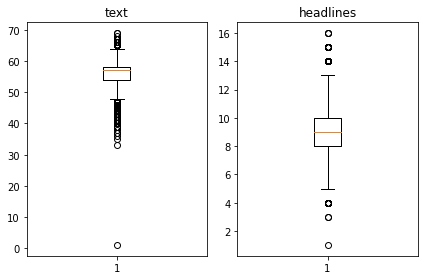

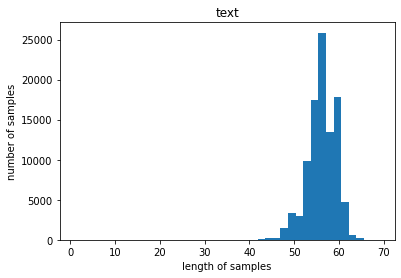

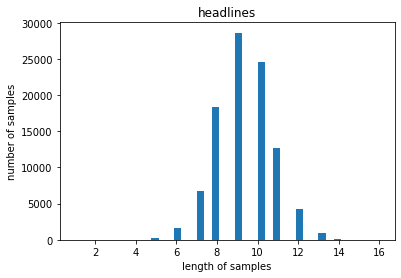

In [18]:
# 샘플 길이 분포 출력
# 각 컬럼의 문장 길이가 길지 않으므로 최대 길이는 미지정
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# 각 컬럼 문장의 최대 길이의 90%만 샘플 길이로 설정
text_max_len = 60
headlines_max_len = 14

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9443777958519723
전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9997763318422123


In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 92872


## 4) 시작 토큰과 종료 토큰 추가하기

In [23]:
# 헤드라인 데이터에 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant an alumnus of upgrad and iiit pg p...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [24]:
data.shape

(92872, 4)

In [25]:
# ndarray 형태로 변환
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [26]:
# 샘플 섞기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[81457 23082 80876 ... 36038 64322 73313]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
# 학습 데이터 나누기
n_of_val = int(len(encoder_input)*0.2)

In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 74298
훈련 레이블의 개수 : 74298
테스트 데이터의 개수 : 18574
테스트 레이블의 개수 : 18574


## 5) 단어 사전(vocabulary) 만들기 및 정수 인코딩

In [30]:
# 인코더 데이터로 단어 사전 생성
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 사전 생성
# src_tokenizer.word_index

In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68114
등장 빈도가 6번 이하인 희귀 단어의 수: 46356
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21758
단어 집합에서 희귀 단어의 비율: 68.05649352556009
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.2725520487494135


In [32]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 사전의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 사전 재생성

In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[40, 57, 207, 100, 7, 4375, 655, 2686, 13461, 143, 460, 10, 766, 2, 8965, 10, 119, 11, 103, 1363, 2, 24, 14, 1, 919, 47, 1844, 18, 153, 844, 123, 91, 925, 79, 41, 26, 547, 2237, 3320, 435, 180, 10, 12, 275, 53, 173, 10997, 5, 1503, 100, 140], [552, 1861, 13045, 12242, 7, 279, 1, 46, 640, 3, 603, 2, 1790, 2135, 349, 3, 157, 162, 3147, 418, 233, 1, 30, 54, 388, 1218, 640, 482, 349, 3, 157, 684, 45, 3124, 1705, 52, 8083, 2098, 5, 1299, 2098, 4580, 316, 1, 721, 280, 8, 1705, 1, 186, 349, 3, 157, 418, 233], [82, 7692, 4, 2265, 7693, 365, 3851, 2190, 983, 14, 7583, 1, 2827, 702, 5, 878, 6292, 4243, 1, 723, 436, 1, 221, 6, 204, 15, 1491, 275, 601, 9293, 21, 26, 1358, 40, 19, 3163, 1, 294, 1657, 1, 82, 572, 35, 878, 4044, 8084, 2827, 926, 5, 702, 4484]]


In [34]:
# 디코더 데이터로 단어 사전 생성
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29502
등장 빈도가 5번 이하인 희귀 단어의 수: 19437
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10065
단어 집합에서 희귀 단어의 비율: 65.88366890380313
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.874327997504646


In [36]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) # 단어 사전 크기 10000 제한
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 716, 30, 5236, 511, 1884, 14, 425, 561], [1, 57, 36, 4, 588, 3, 1266, 292, 4, 276, 290], [1, 490, 1281, 662, 9, 9189, 5028, 8490], [1, 26, 19, 1885, 3, 95, 5, 2119, 3, 1006, 3123, 3, 603], [1, 2489, 195, 4656, 158, 1697, 121, 4, 656]]
target
decoder  [[716, 30, 5236, 511, 1884, 14, 425, 561, 2], [57, 36, 4, 588, 3, 1266, 292, 4, 276, 290, 2], [490, 1281, 662, 9, 9189, 5028, 8490, 2], [26, 19, 1885, 3, 95, 5, 2119, 3, 1006, 3123, 3, 603, 2], [2489, 195, 4656, 158, 1697, 121, 4, 656, 2]]


In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 74297
훈련 레이블의 개수 : 74297
테스트 데이터의 개수 : 18574
테스트 레이블의 개수 : 18574


## 6) 패딩하기

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

## 1) 모델 설계

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output2)

In [40]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [41]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 2) 어텐션 메커니즘

In [42]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 3) 모델 훈련

In [44]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50) 

Epoch 1/50
291/291 [==============================] - 248s 825ms/step - loss: 4.7733 - val_loss: 4.4571
Epoch 2/50
291/291 [==============================] - 238s 819ms/step - loss: 4.3022 - val_loss: 4.0465
Epoch 3/50
291/291 [==============================] - 238s 817ms/step - loss: 3.9032 - val_loss: 3.7599
Epoch 4/50
291/291 [==============================] - 237s 813ms/step - loss: 3.6119 - val_loss: 3.5679
Epoch 5/50
291/291 [==============================] - 235s 808ms/step - loss: 3.3841 - val_loss: 3.4376
Epoch 6/50
291/291 [==============================] - 234s 803ms/step - loss: 3.1985 - val_loss: 3.3401
Epoch 7/50
291/291 [==============================] - 234s 803ms/step - loss: 3.0432 - val_loss: 3.2719
Epoch 8/50
291/291 [==============================] - 235s 808ms/step - loss: 2.9085 - val_loss: 3.2211
Epoch 9/50
291/291 [==============================] - 234s 805ms/step - loss: 2.7901 - val_loss: 3.1892
Epoch 10/50
291/291 [==============================] - 233s 802m

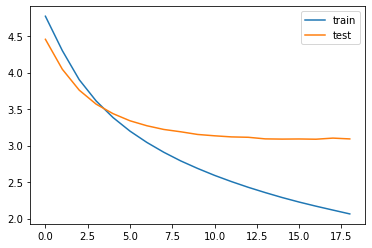

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

## 1) 인퍼런스 모델 구현

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [51]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [52]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 2) 모델 테스트

In [53]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [153]:
# 각 열에 해당하는 리스트 초기화
original_text = []
actual_summary = []
predicted_summary = []
indices = []

# 출력을 리스트에 추가
for i in range(80, 90):
    original_text.append(seq2text(encoder_input_test[i]))
    actual_summary.append(seq2summary(decoder_input_test[i]))
    predicted_summary.append(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    indices.append(i)

# 데이터프레임 생성
acc_data = {
    'Index': indices,
    '원문': original_text,
    '실제요약(Abstractive)': actual_summary,
    '예측요약(Abstractive)': predicted_summary
}

df = pd.DataFrame(acc_data)
df

,Index,원문,실제요약(Abstractive),예측요약(Abstractive)
0,80,australian commentator kerry keeffe has apolog...,aus commentator apologises after insulting deb...,england captain apologises for tests india tests
1,81,the reserve bank of india on tuesday said it h...,rbi scales up to cr in december,rbi to get cr from hdfc bank for crore
2,82,uber chief executive officer dara khosrowshahi...,india is key of our growth plan uber ceo,we are not profitable uber ceo dara khosrowshahi
3,83,technology major microsoft ceo satya nadella d...,get real computer microsoft ceo to ipad users,microsoft ceo responds to us open on microsoft
4,84,couple caught in mexico transporting human bod...,couple transporting body parts admits to killi...,pet dog saves baby nurse who saved her pet dogs
5,85,reacting to pakistani player tying of indian v...,moment of match tweets user on pak player tyin...,india has no place in wc tweets user on wc final
6,86,former general motors vice chairman bob in an ...,tesla headed for the graveyard former general ...,we have no longer to be ousted ex gm executiv...
7,87,cuba is reviving network of state run love in ...,cuba to reopen state run pay per hour love,russian tv channel to get married to
8,88,mukesh ambani wife nita ambani along with son ...,nita ambani offers son engagement card at temple,isha ambani anand piramal to get engaged to s...
9,89,animal rights group society international indi...,group working to rescue stranded animals from ...,kerala rescue rescue of rescue ops


In [154]:
# 데이터가 랜덤하게 섞여 있기에, 추출적 요약과의 비교를 위해 데이터 1개만 csv로 저장
seq_result = df.iloc[[6]]
seq_result.to_csv('seq_df.csv', index=False) 

# Step 5. Summa을 이용해서 추출적 요약해보기

In [87]:
import requests
from summa.summarizer import summarize

In [142]:
original = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [155]:
sum_indices = []
sum_text = []
sum_head = []
sum_suma = []


for i in range(16658, 16663):
    sum_indices.append(i)
    sum_text.append(original['text'][i])
    sum_head.append(original['headlines'][i])
    sum_suma.append(summarize(original['text'][i], ratio=0.4))


# for i in range(0, 10):
#     print("원문 :", original['text'][i])
#     print("실제 요약 :", original['headlines'][i])
#     print("예측 요약 :", summarize(original['text'][i], ratio=0.4))

sum_data = {
    'index':sum_indices,
    '원문':sum_text,
    '실제요약(Extractive)':sum_head,
    '예측요약(Extractive)':sum_suma
}

sum_df = pd.DataFrame(sum_data)
sum_df

,index,원문,실제요약(Extractive),예측요약(Extractive)
0,16658,"Former General Motors Vice Chairman Bob Lutz, ...",Tesla headed for the graveyard: Former General...,"Former General Motors Vice Chairman Bob Lutz, ..."
1,16659,Japanese automaker Nissan has unveiled its 'Na...,Truck concept that functions as a mobile astro...,The trailer module's mechanised roof opens to ...
2,16660,British car manufacturer Panasonic Jaguar Raci...,Jaguar's next-gen Formula E car goes 0-100 kmp...,With a minimum weight of 900 kg including the ...
3,16661,Bengaluru-based grocery startup DailyNinja has...,"Grocery startup raises funding led by Matrix, ...",Bengaluru-based grocery startup DailyNinja has...
4,16662,A professor has been jailed for life in Hong K...,"Man who killed wife, daughter with yoga ball j...",His wife and daughter were found by the roadsi...


In [159]:
# 추상적 요약과의 비교를 위해 데이터 샘플 1개만 저장
sum_result = sum_df.iloc[[0]]
sum_result.to_csv('sum_df.csv', index=False) 

# Step 6. 추출적 요약과 추상적 요약 비교

In [6]:
# 추상적 요약 1개 샘플
# 실제 데이터의 인덱스 번호는 16658이나, 데이터 전처리 과정에서 랜덤하게 섞였으므로 86으로 지정됨
ab_sum = pd.read_csv('seq_df.csv')
ab_sum

,Index,원문,실제요약(Abstractive),예측요약(Abstractive)
0,86,former general motors vice chairman bob in an ...,tesla headed for the graveyard former general ...,we have no longer to be ousted ex gm executiv...


In [8]:
# 추출적 요약 1개 샘플
ex_sum = pd.read_csv('sum_df.csv')
ex_sum

,index,원문,실제요약(Extractive),예측요약(Extractive)
0,16658,"Former General Motors Vice Chairman Bob Lutz, ...",Tesla headed for the graveyard: Former General...,"Former General Motors Vice Chairman Bob Lutz, ..."


In [18]:
# 예측요약 부분만 출력해서 비교
print('원문:', ex_sum.iloc[0, 1])
print('''번역: 전 제너럴 모터스 부회장인 밥 루츠는 CNBC와의 인터뷰에서 테슬라를 
"무덤으로 향하는 자동차 회사"라고 말했습니다. 
"그들은 모델 3로 결코 돈을 벌지 못할 것입니다."라고 그는 덧붙였습니다. 
"조립 공장에서 9,000명의 직원이 연간 15만 대 미만의 자동차를 생산하고 있습니다. 
모든 것이 계산되지 않았습니다."라고 그는 덧붙였습니다.''')
print('---'*15)
print('추상적 요약:', ab_sum.iloc[0, 3])
print('번역: 우리는 더 이상 전 GM 최고경영자를 쫓아내지 않아도 됩니다.')
print('---'*15)
print('추출적 요약:', ex_sum.iloc[0, 3])
print('''번역: 전 제너럴 모터스 부회장인 밥 루츠는 CNBC와의 인터뷰에서 테슬라를 
"무덤으로 향하는 자동차 회사"라고 말했습니다. 
그는 "그들은 모델 3로 결코 돈을 벌지 못할 것"이라고 덧붙였습니다.''')

원문: Former General Motors Vice Chairman Bob Lutz, in an interview with CNBC, said that Tesla is "an automobile company that is headed for the graveyard." "They will never make money on the Model 3," he added. "He's got 9,000 people in that assembly plant producing less than 150,000 cars a year. The whole thing just doesn't compute," he further said. 
번역: 전 제너럴 모터스 부회장인 밥 루츠는 CNBC와의 인터뷰에서 테슬라를 
"무덤으로 향하는 자동차 회사"라고 말했습니다. 
"그들은 모델 3로 결코 돈을 벌지 못할 것입니다."라고 그는 덧붙였습니다. 
"조립 공장에서 9,000명의 직원이 연간 15만 대 미만의 자동차를 생산하고 있습니다. 
모든 것이 계산되지 않았습니다."라고 그는 덧붙였습니다.
---------------------------------------------
추상적 요약:  we have no longer to be ousted ex gm executive chief
번역: 우리는 더 이상 전 GM 최고경영자를 쫓아내지 않아도 됩니다.
---------------------------------------------
추출적 요약: Former General Motors Vice Chairman Bob Lutz, in an interview with CNBC, said that Tesla is "an automobile company that is headed for the graveyard." "They will never make money on the Model 3," he added.
번역: 전 제너럴 모터스 부회장인 밥 루츠는 CNBC와의 인터뷰에서 테슬라를

# 회고(위 문장 추출 분석)

- 추상적은 요약은 정말로 원문의 추상적인 부분만을 요약한 것 같음. 그렇기에 원문의 본 내용의 정보와 맥락이 많이 소실된 것 같은 인상을 줌.
- 추출적 요약은 원문의 내용을 있는 그대로 가져왔기에, 정보의 손실은 거의 없는 것 같음. 원문 뒷 부분에 불필요한 문장('The whole thing just doesn't compute')은 삭제함
- 모델의 성능이 좋을 떄는 추상적 요약이 유용할 수 있으나, 모델 성능이 안 좋으면 추출적 요약을 사용하는 게 좋을 수 있음